In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
from PIL import Image
import random
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import os



In [2]:
# Set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Menggunakan device: {device}")



Menggunakan device: cuda


In [3]:
# --- Fungsi Utility dan Visualisasi ---
def img_show(number, root_path="/kaggle/input/guns-object-detection/", size=5):
    """Menampilkan gambar dengan bounding box dari file label."""
    image_path = os.path.join(root_path, "Images", f"{number}.jpeg")
    label_path = os.path.join(root_path, "Labels", f"{number}.txt")

    if not os.path.exists(image_path) or not os.path.exists(label_path):
        print(f"File tidak ditemukan: {number}")
        return

    image = cv2.imread(image_path)
    file_data = open(label_path).readlines()
    num_objects = int(file_data[0].strip())

    for i in range(num_objects):
        coords = [int(x) for x in file_data[i+1].split()]
        start_pt = (coords[0], coords[1])
        end_pt = (coords[2], coords[3])
        cv2.rectangle(image, start_pt, end_pt, (0, 0, 255), 2)

    aspect_ratio = image.shape[0] / image.shape[1]
    plt.figure(figsize=(size * aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"No. of guns: {num_objects}")
    plt.axis('off')
    plt.show()



In [4]:
# --- Dataset dan Dataloader ---
class GunData(Dataset):
    def __init__(self, root):
        self.image_path = os.path.join(root, "Images")
        self.labels_path = os.path.join(root, "Labels")
        self.images = sorted(os.listdir(self.image_path))

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0
        img = torch.as_tensor(img).permute(2, 0, 1)

        label_name = img_name.replace(".jpeg", ".txt")
        label_path = os.path.join(self.labels_path, label_name)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            num_objects = int(lines[0].strip())
            boxes = [list(map(int, line.split())) for line in lines[1:num_objects+1]]

        if not boxes:
            boxes = np.zeros((0, 4), dtype=np.float32)
            labels = np.zeros((0,), dtype=np.int64)
            area = np.zeros((0,), dtype=np.float32)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.ones((len(boxes),), dtype=torch.int64)
            area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

        target = {
            "boxes": boxes,
            "labels": labels,
            "area": area,
            "image_id": torch.tensor([idx])
        }

        return img, target

    def __len__(self):
        return len(self.images)

def collate_fn(batch):
    return tuple(zip(*batch))



In [5]:
# --- Model dan Pelatihan ---
class Model:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.model = self._create_model()
        self.train_losses = []
        self.val_losses = []

    def _create_model(self):
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num_classes)
        return model

    def train_and_validate(self, train_loader, val_loader, optimizer, num_epochs=30):
        self.model.to(device)
        self.optimizer = optimizer

        for epoch in tqdm(range(num_epochs)):
            self.model.train()
            train_loss = 0
            for images, targets in train_loader:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                self.optimizer.zero_grad()
                losses.backward()
                self.optimizer.step()
                train_loss += losses.item()
            
            # Tambahkan train loss ke daftar
            self.train_losses.append(train_loss / len(train_loader))

            print(f"\nEpoch: {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f}")
            self._validate(val_loader)
            
        self.plot_losses()

    def _validate(self, val_loader):
        self.model.train()
        val_loss = 0
        with torch.no_grad():
            for images, targets in val_loader:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                val_loss += losses.item()
        
        # Tambahkan validation loss ke daftar
        self.val_losses.append(val_loss / len(val_loader))
        print(f"Validation Loss: {val_loss:.4f}")

    def save_model(self, path="F_RCNN.pth"):
        torch.save(self.model.state_dict(), path)
        print(f"Model berhasil disimpan di {path}")

    def plot_losses(self):
        """Visualisasi Loss Pelatihan dan Validasi."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Training Loss', marker='o')
        plt.plot(self.val_losses, label='Validation Loss', marker='o')
        plt.title('Training and Validation Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 205MB/s] 


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 1/30 | Train Loss: 21.7106
Validation Loss: 5.0697

Epoch: 2/30 | Train Loss: 16.4765
Validation Loss: 4.9249

Epoch: 3/30 | Train Loss: 14.2139
Validation Loss: 4.2446

Epoch: 4/30 | Train Loss: 12.6499
Validation Loss: 4.2204

Epoch: 5/30 | Train Loss: 11.2053
Validation Loss: 4.2073

Epoch: 6/30 | Train Loss: 9.8158
Validation Loss: 4.6892

Epoch: 7/30 | Train Loss: 8.3783
Validation Loss: 4.8350

Epoch: 8/30 | Train Loss: 8.0196
Validation Loss: 4.5062

Epoch: 9/30 | Train Loss: 6.8033
Validation Loss: 4.8855

Epoch: 10/30 | Train Loss: 6.2571
Validation Loss: 4.4006

Epoch: 11/30 | Train Loss: 5.4436
Validation Loss: 5.3919

Epoch: 12/30 | Train Loss: 5.2536
Validation Loss: 4.8645

Epoch: 13/30 | Train Loss: 4.9625
Validation Loss: 5.0797

Epoch: 14/30 | Train Loss: 5.0461
Validation Loss: 5.1742

Epoch: 15/30 | Train Loss: 4.6870
Validation Loss: 6.2074

Epoch: 16/30 | Train Loss: 4.3624
Validation Loss: 4.9155

Epoch: 17/30 | Train Loss: 4.2417
Validation Loss: 5.8594



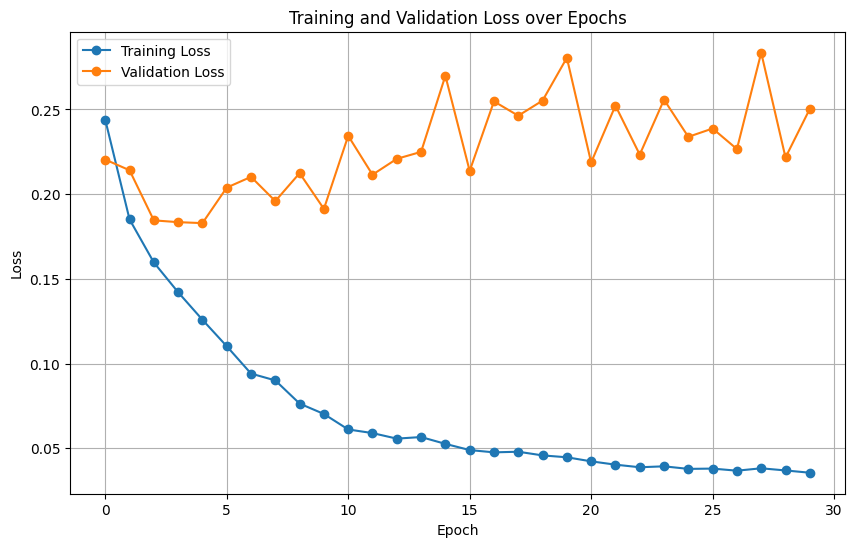

Model berhasil disimpan di F_RCNN.pth


In [6]:
# --- Inisialisasi dan Pelatihan ---
dataset = GunData("/kaggle/input/guns-object-detection/")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False, num_workers=0, collate_fn=collate_fn)

NUM_CLASSES = 2
rcnn_model = Model(NUM_CLASSES)
optimizer = optim.Adam(rcnn_model.model.parameters(), lr=0.0001)

rcnn_model.train_and_validate(train_loader, val_loader, optimizer, num_epochs=30)
rcnn_model.save_model()

Menggunakan device: cuda
Tidak ada objek yang terdeteksi dengan skor di atas threshold.


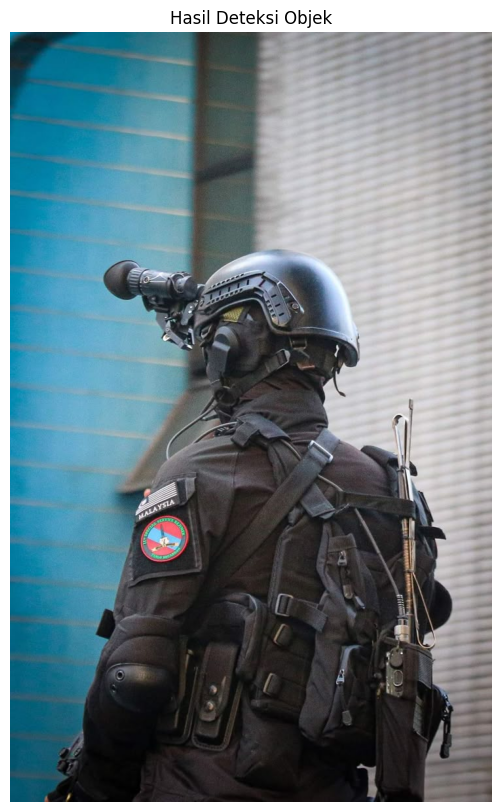

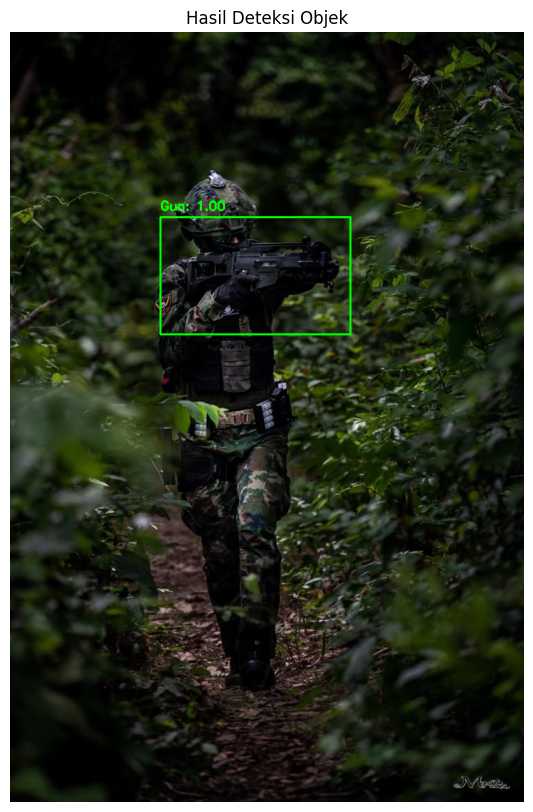

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import os
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision

# Set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Menggunakan device: {device}")

# --- Load Model yang Sudah Terlatih ---
def get_model(num_classes):
    """Fungsi untuk memuat arsitektur model."""
    model = fasterrcnn_resnet50_fpn(pretrained=False) # False karena kita hanya memuat bobot
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def load_trained_model(model_path, num_classes):
    """Fungsi untuk memuat bobot model yang sudah dilatih."""
    model = get_model(num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval() # Atur model ke mode evaluasi
    return model

# Tentukan jalur file model Anda
MODEL_PATH = "F_RCNN.pth"
NUM_CLASSES = 2 # 1 kelas objek (gun) + 1 kelas background
model = load_trained_model(MODEL_PATH, NUM_CLASSES)

# --- Fungsi Prediksi dan Visualisasi ---
def process_image_and_predict(image_path, model, score_threshold=0.7):
    """
    Memuat gambar, melakukan prediksi, dan mengembalikan hasil.
    Args:
        image_path (str): Jalur menuju file gambar.
        model (torch.nn.Module): Model Faster R-CNN yang sudah terlatih.
        score_threshold (float): Batasan skor untuk menampilkan bounding box.
    Returns:
        tuple: Tuple berisi gambar asli (numpy array) dan hasil prediksi.
    """
    # Memuat dan memproses gambar
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Tidak bisa memuat gambar dari {image_path}")
        return None, None
        
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image_tensor = torch.as_tensor(image_rgb / 255.0).permute(2, 0, 1)

    # Lakukan prediksi
    with torch.no_grad():
        predictions = model([image_tensor.to(device)])
    
    # Ambil hasil dari prediksi pertama (batch_size = 1)
    preds = predictions[0]

    # Terapkan Non-Maximum Suppression (NMS)
    keep = torchvision.ops.nms(preds['boxes'], preds['scores'], iou_threshold=0.5)
    
    final_preds = {
        'boxes': preds['boxes'][keep].cpu().numpy(),
        'scores': preds['scores'][keep].cpu().numpy(),
        'labels': preds['labels'][keep].cpu().numpy()
    }
    
    # Filter hasil berdasarkan score_threshold
    filtered_preds = {
        'boxes': final_preds['boxes'][final_preds['scores'] > score_threshold],
        'scores': final_preds['scores'][final_preds['scores'] > score_threshold],
        'labels': final_preds['labels'][final_preds['scores'] > score_threshold]
    }
    
    return image, filtered_preds

def plot_predictions(original_image, predictions, title="Hasil Deteksi Objek"):
    """
    Menggambar bounding box dari prediksi pada gambar asli.
    """
    img_display = original_image.copy()
    
    if len(predictions['boxes']) == 0:
        print("Tidak ada objek yang terdeteksi dengan skor di atas threshold.")
    else:
        for box, score in zip(predictions['boxes'], predictions['scores']):
            # Ambil koordinat bounding box
            x1, y1, x2, y2 = box.astype(int)
            
            # Gambar bounding box
            cv2.rectangle(img_display, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Tulis skor di atas box
            label_text = f"Gun: {score:.2f}"
            cv2.putText(img_display, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Tampilkan gambar
    plt.figure(figsize=(12, 10))
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- Contoh Penggunaan ---
# Ganti dengan path gambar yang ingin Anda uji
TEST_IMAGE_PATH = "/kaggle/input/cobacoba/11 RGK.jpeg" 
# Lakukan prediksi
original_image, predictions = process_image_and_predict(TEST_IMAGE_PATH, model)

# Tampilkan hasil
if original_image is not None:
    plot_predictions(original_image, predictions)

# --- Contoh Penggunaan ---
# Ganti dengan path gambar yang ingin Anda uji
TEST_IMAGE_PATH2 = "/kaggle/input/cobacoba/download.jpeg" 
# Lakukan prediksi
original_image, predictions = process_image_and_predict(TEST_IMAGE_PATH2, model)

# Tampilkan hasil
if original_image is not None:
    plot_predictions(original_image, predictions)